#### Dependencies #### 


In [16]:
import pandas as pd, numpy as np, os, sys, seaborn as sns, matplotlib.pyplot as plt 

sys.path.append('./')
sys.path.append('../')
sys.path.append('../../')


# load ing arff files 
from scipy.io import arff


#### GLobals #### 


In [11]:

DATAPATH = os.path.join("./data/","ThoraricSurgery.arff")


' raw data'

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
120,b'DGN2',3.84,2.56,b'PRZ1',b'F',b'F',b'F',b'T',b'F',b'OC11',b'F',b'F',b'F',b'F',b'F',59.0,b'F'
7,b'DGN2',3.19,2.50,b'PRZ1',b'F',b'F',b'F',b'T',b'F',b'OC11',b'F',b'F',b'T',b'T',b'F',66.0,b'T'
19,b'DGN3',2.88,2.48,b'PRZ0',b'F',b'F',b'F',b'F',b'F',b'OC11',b'F',b'F',b'F',b'T',b'F',71.0,b'F'
238,b'DGN5',3.40,2.08,b'PRZ1',b'F',b'F',b'F',b'F',b'T',b'OC11',b'F',b'F',b'F',b'T',b'F',55.0,b'T'
402,b'DGN3',2.96,2.20,b'PRZ1',b'F',b'F',b'F',b'T',b'F',b'OC12',b'F',b'F',b'F',b'T',b'F',53.0,b'F'


#### Background #### 

#### Data source ####



Kaggle: https://www.kaggle.com/datasets/sid321axn/thoraric-surgery/data

The original (and better) curated dataset can be retrieved from here
https://archive.ics.uci.edu/dataset/277/thoracic+surgery+data

1. DGN: Diagnosis - specific combination of ICD-10 codes for primary and secondary as well multiple tumours if any (DGN3,DGN2,DGN4,DGN6,DGN5,DGN8,DGN1)
2. PRE4: Forced vital capacity - FVC (numeric)
3. PRE5: Volume that has been exhaled at the end of the first second of forced expiration - FEV1 (numeric)
4. PRE6: Performance status - Zubrod scale (PRZ2,PRZ1,PRZ0)
5. PRE7: Pain before surgery (T,F)
6. PRE8: Haemoptysis before surgery (T,F)
7. PRE9: Dyspnoea before surgery (T,F)
8. PRE10: Cough before surgery (T,F)
9. PRE11: Weakness before surgery (T,F)
10. PRE14: T in clinical TNM - size of the original tumour, from OC11 (smallest) to OC14 (largest) (OC11,OC14,OC12,OC13)
11. PRE17: Type 2 DM - diabetes mellitus (T,F)
12. PRE19: MI up to 6 months (T,F)
13. PRE25: PAD - peripheral arterial diseases (T,F)
14. PRE30: Smoking (T,F)
15. PRE32: Asthma (T,F)
16. AGE: Age at surgery (numeric)
17. Risk1Y: 1 year survival period - (T)rue value if died (T,F)


## Content ##
The data is dedicated to classification problem related to the post-operative life expectancy in the lung cancer patients after thoracic surgery in 
which there are two classes class 1 - the death of patients within one year after surgery and class 2 – the patients who survive.
The data was collected retrospectively at Wroclaw Thoracic Surgery Centre for patients who underwent major lung resections for 
primary lung cancer in the years 2007 to 2011. The Centre is associated with the Department of Thoracic Surgery of the Medical University of 
Wroclaw and Lower-Silesian Centre for Pulmonary Diseases, Poland, while the research database constitutes a part of the National Lung Cancer 
Registry, administered by the Institute of Tuberculosis and Pulmonary Diseases in Warsaw, Poland.

Globals

In [22]:
# kaggle DATAPATH =  os.path.join(".//data//","ThoraricSurgery.csv")  

# original dataset. 
DATAPATH =  os.path.join(".//data//","ThoraricSurgery.arff")  

# Load datset 

In [6]:
def preprocess_dataset_types( df ):

    # give the columns a mnore meaningful name based on the dataset description 
    column_names = {'DGN': 'diagnosis',
                    'PRE4': 'fvc',
                    'PRE5': 'fev1',
                    'PRE6': 'performance', 
                    'PRE7': 'pain',
                    'PRE8': 'haemoptysis', 
                    'PRE9': 'dyspnoea',
                    'PRE10': 'cough',
                    'PRE11': 'weakness',
                    'PRE14': 'tumor_size', #from OC11 (smallest) to OC14 (largest) (OC11,OC14,OC12,OC13)
                    'PRE17': 'diabetes', 
                    'PRE19': 'mi_6months',
                    'PRE25': 'pad', 
                    'PRE30': 'smoking', 
                    'PRE32': 'asthma',
                    'AGE': 'age',
                    'Risk1Yr': 'target'
    }

    df.rename( column_names, inplace = True, axis = 1 )
    columns = df.columns 

    # all those bytes need to be converted to str 
    # and then potentially to other types 
    numeric_columns = df.select_dtypes( np.number )
    str_df = df.select_dtypes([object])
    str_df = str_df.stack().str.decode('utf-8').unstack()

    for col in numeric_columns.columns: 
        str_df[col] = numeric_columns[col].values 

    # keep the origuinal order of the columnns 
    str_df = str_df[  columns ]


    # process the data types based on description 
    bool_columns= list(set( str_df.columns ).difference( ['diagnosis','fvc', 'fev1', 'performance','tumor_size', 'age'] ))
    str_df[ bool_columns ] = str_df[ bool_columns ].apply( lambda x: np.where( x == 'F',  False, np.where( x == 'T', True, x )))
    str_df[ bool_columns ] = str_df[bool_columns].astype( np.int32 ) 

    str_df['tumor_size'] = str_df['tumor_size'].str[-2:].astype( np.int32 )
    str_df['performance'] = str_df['performance'].str[-1:].astype( np.int32 )
    str_df['diagnosis'] = str_df['diagnosis'].str[-1:].astype( np.int32 )

    float_columns = ['fvc', 'fev1','age'] 
    str_df[ float_columns ] = str_df[ float_columns ].astype( np.float32 )

    str_df['target'] = str_df['target'].astype( np.int32 )


    return str_df 
    
 


In [83]:
l = [1,2,3,4]
l.remove(2)
l

[1, 3, 4]

In [89]:
df = pd.DataFrame(arff.loadarff(DATAPATH)[0])
display( ' raw data', df.sample(5))
print( 50*'-')

df = preprocess_dataset_types(  df )   
display( ' pre-processed', df.head( 5 ) )
display( round( df.describe(),2) ) 
display( pd.DataFrame( df.dtypes ).T ) 
print( ' Null values',df.isnull().sum().any()  )   
print( ' Duplicates ? ', df[df.duplicated()].sum().any() )

numerical_features = ['fvc', 'fev1', 'age' ]
categorical_features = list( set( df.columns ).difference( numerical_features ))
categorical_features.remove('target') 
ordinal_features = ['performance', 'tumor_size']  # ?diagnosis 
nominal_features = ['diagnosis',  'haemoptysis', 'dyspnoea', 'mi_6months', 'diabetes', 'weakness', 'pain', 'asthma', 'smoking', 'pad', 'cough']

print() 
print(' continuous features ', numerical_features )
print(' discrete features ', categorical_features ) 
print(' ordinal features ', ordinal_features ); print (' ?diagnosis ordinal ')
print(' nominal features ', nominal_features );  


' raw data'

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
213,b'DGN3',2.22,1.36,b'PRZ0',b'F',b'F',b'F',b'F',b'F',b'OC12',b'T',b'F',b'F',b'T',b'F',63.0,b'T'
42,b'DGN3',3.20,2.82,b'PRZ1',b'F',b'F',b'F',b'T',b'F',b'OC12',b'F',b'F',b'F',b'T',b'F',68.0,b'F'
77,b'DGN3',3.04,3.60,b'PRZ1',b'F',b'F',b'F',b'T',b'F',b'OC12',b'F',b'F',b'F',b'T',b'F',62.0,b'T'
158,b'DGN3',3.08,2.32,b'PRZ1',b'F',b'T',b'F',b'T',b'T',b'OC12',b'F',b'F',b'T',b'T',b'F',61.0,b'F'
81,b'DGN3',1.96,1.68,b'PRZ1',b'F',b'F',b'F',b'T',b'F',b'OC14',b'F',b'F',b'F',b'T',b'F',59.0,b'F'


--------------------------------------------------


' pre-processed'

,diagnosis,fvc,fev1,performance,pain,haemoptysis,dyspnoea,cough,weakness,tumor_size,diabetes,mi_6months,pad,smoking,asthma,age,target
0,2,2.88,2.16,1,0,0,0,1,1,14,0,0,0,1,0,60.0,0
1,3,3.40,1.88,0,0,0,0,0,0,12,0,0,0,1,0,51.0,0
2,3,2.76,2.08,1,0,0,0,1,0,11,0,0,0,1,0,59.0,0
3,3,3.68,3.04,0,0,0,0,0,0,11,0,0,0,0,0,54.0,0
4,3,2.44,0.96,2,0,1,0,1,1,11,0,0,0,1,0,73.0,1


,diagnosis,fvc,fev1,performance,pain,haemoptysis,dyspnoea,cough,weakness,tumor_size,diabetes,mi_6months,pad,smoking,asthma,age,target
count,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00
mean,3.10,3.28,4.57,0.78,0.07,0.14,0.07,0.69,0.17,11.74,0.07,0.00,0.02,0.82,0.00,62.53,0.15
std,0.72,0.87,11.77,0.54,0.25,0.35,0.25,0.46,0.37,0.70,0.26,0.07,0.13,0.38,0.07,8.71,0.36
min,1.00,1.44,0.96,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,0.00,0.00,0.00,0.00,21.00,0.00
25%,3.00,2.60,1.96,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,0.00,0.00,1.00,0.00,57.00,0.00
50%,3.00,3.16,2.40,1.00,0.00,0.00,0.00,1.00,0.00,12.00,0.00,0.00,0.00,1.00,0.00,62.00,0.00
75%,3.00,3.81,3.08,1.00,0.00,0.00,0.00,1.00,0.00,12.00,0.00,0.00,0.00,1.00,0.00,69.00,0.00
max,8.00,6.30,86.30,2.00,1.00,1.00,1.00,1.00,1.00,14.00,1.00,1.00,1.00,1.00,1.00,87.00,1.00


,diagnosis,fvc,fev1,performance,pain,haemoptysis,dyspnoea,cough,weakness,tumor_size,diabetes,mi_6months,pad,smoking,asthma,age,target
0,int32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,int32


 Null values False
 Duplicates ?  False

 continuous features  ['fvc', 'fev1', 'age']
 discrete features  ['diagnosis', 'tumor_size', 'haemoptysis', 'dyspnoea', 'mi_6months', 'performance', 'diabetes', 'weakness', 'pain', 'asthma', 'smoking', 'pad', 'cough']
 ordinal features  ['performance', 'tumor_size']
 ?diagnosis ordinal 
 nominal features  ['diagnosis', 'haemoptysis', 'dyspnoea', 'mi_6months', 'diabetes', 'weakness', 'pain', 'asthma', 'smoking', 'pad', 'cough']


# Feature selection 

In [127]:
def compute_iqr_ouliers( df, scale = 1.5  ):
    X = df.select_dtypes( np.number ) 

    q1,q3 =   X.quantile(0.25), X.quantile(0.75)
    iqr = q3 - q1
    iqr_min =  q1 - scale*iqr
    iqr_max =  q3 + scale*iqr

    #mask table true/false
    outliers_df = (X > iqr_max) |  (X < iqr_min)

    #bounds table
    iqr_df = pd.concat( [iqr, q1,q3, iqr_min, iqr_max],axis= 1)
    iqr_df.columns = ['IQR', 'Q1','Q3','lower bound', 'upper bound']
    median = pd.DataFrame( X.median(), columns =['median'] )
    iqr_df =  pd.concat( [median, iqr_df], axis= 1  )
    count = pd.DataFrame( outliers_df.sum(), columns =['outliers'] )
    iqr_df = pd.concat( [iqr_df,count], axis = 1)
    return iqr_df 

X = df[ numerical_features ]
iqr_df = compute_iqr_ouliers( X, scale = 1.7  )
iqr_df


,median,IQR,Q1,Q3,lower bound,upper bound,outliers
fvc,3.16,1.2075,2.60,3.8075,0.54725,5.86025,2
fev1,2.40,1.1200,1.96,3.0800,0.05600,4.98400,16
age,62.00,12.0000,57.00,69.0000,36.60000,89.40000,1


fvc      5.61875
fev1     4.76000
age     87.00000
dtype: float64

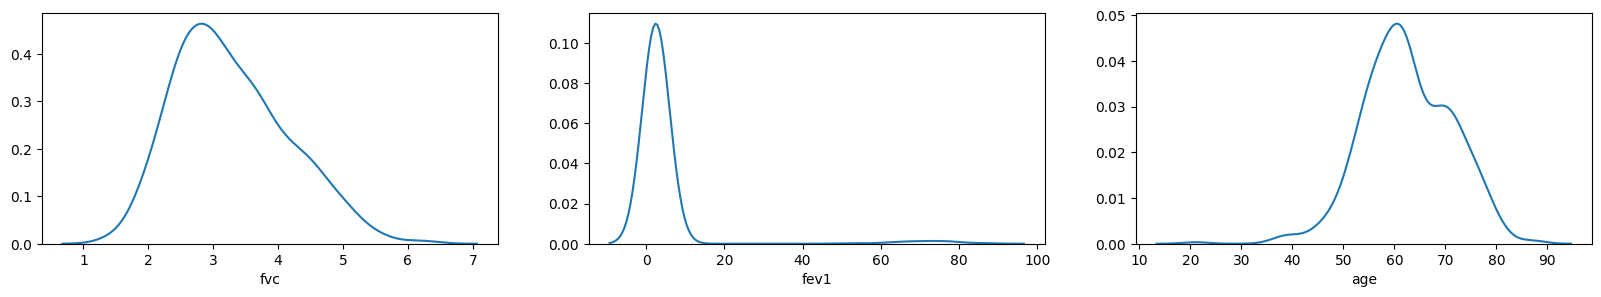

In [18]:
def plot_distribution_and_intervals(data, bounds = None, title="",figsize= (20,3 )):

  df = data.select_dtypes(np.number)
  fig, ax = plt.subplots( nrows = 1, ncols = df.shape[1] , figsize= figsize )

  for n,col in enumerate(df.columns):
    a = sns.kdeplot( df[col],  ax = ax[n], cumulative=False )
    a.set_ylabel(None)

    if bounds is not None:
      if not col in bounds.index:
        continue
      x1,x2 = bounds.loc[col,'lower bound'], bounds.loc[col,'upper bound']
      y1, y2 = a.get_ylim()[0] - a.get_ylim()[1]*0.01 , a.get_ylim()[1]
      a.vlines( x = x1, ymin = y1, ymax = y2, color = 'red' )
      a.vlines( x = x2, ymin = y1, ymax = y2, color = 'red' )

  fig.suptitle(title)
  plt.show()


plot_distribution_and_intervals( df.select_dtypes( np.float32 ) , bounds = None, title="",figsize= (20,3 ))


In [189]:
df.select_dtypes( np.float32 )

,fvc,fev1,age
0,2.88,2.16,60.0
1,3.40,1.88,51.0
2,2.76,2.08,59.0
3,3.68,3.04,54.0
4,2.44,0.96,73.0
...,...,...,...
465,3.88,2.12,63.0
466,3.76,3.12,61.0
467,3.04,2.08,52.0
468,1.96,1.68,79.0


/tmp/ipykernel_3440/4010410138.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  _=df.hist( bins = 50, ax= ax )


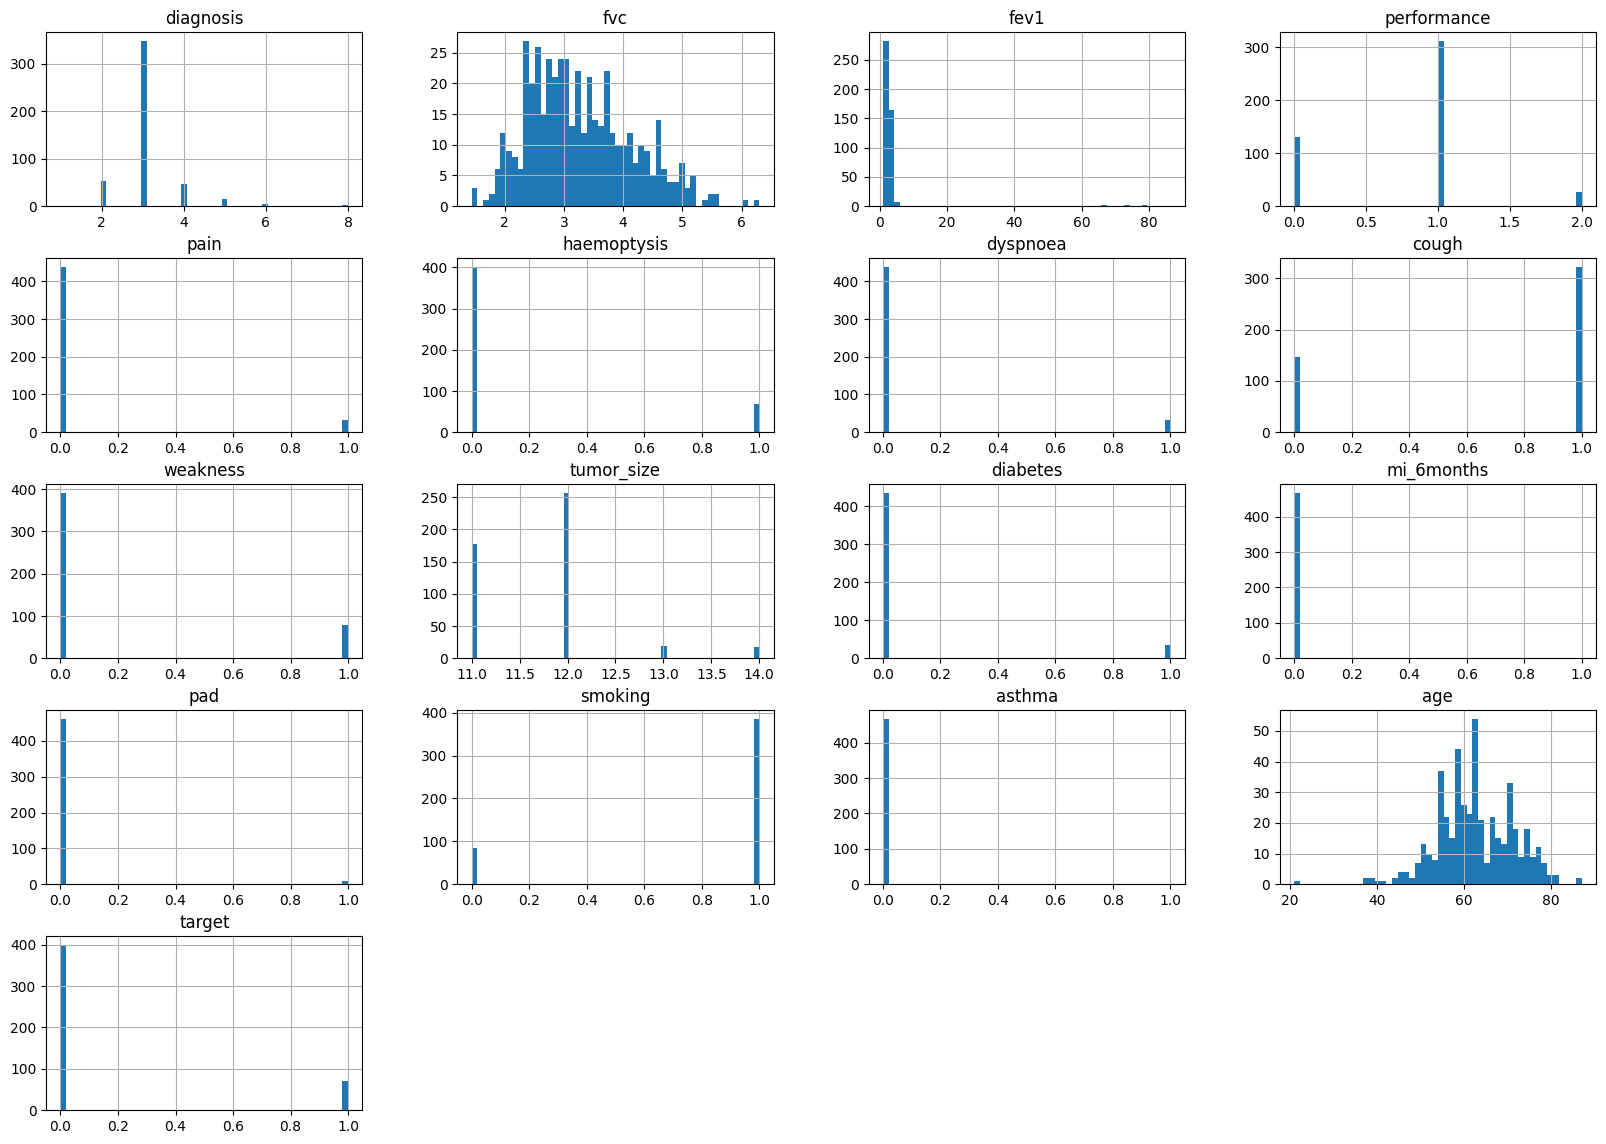

2.080000     16
2.360000     14
2.160000     13
1.880000     12
2.320000     12
             ..
2.900000      1
2.110000      1
72.800003     1
4.080000      1
4.100000      1
Name: fev1, Length: 136, dtype: int64

In [186]:
fig,ax = plt.subplots( figsize = (20,14))
_=df.hist( bins = 50, ax= ax )
plt.show() 



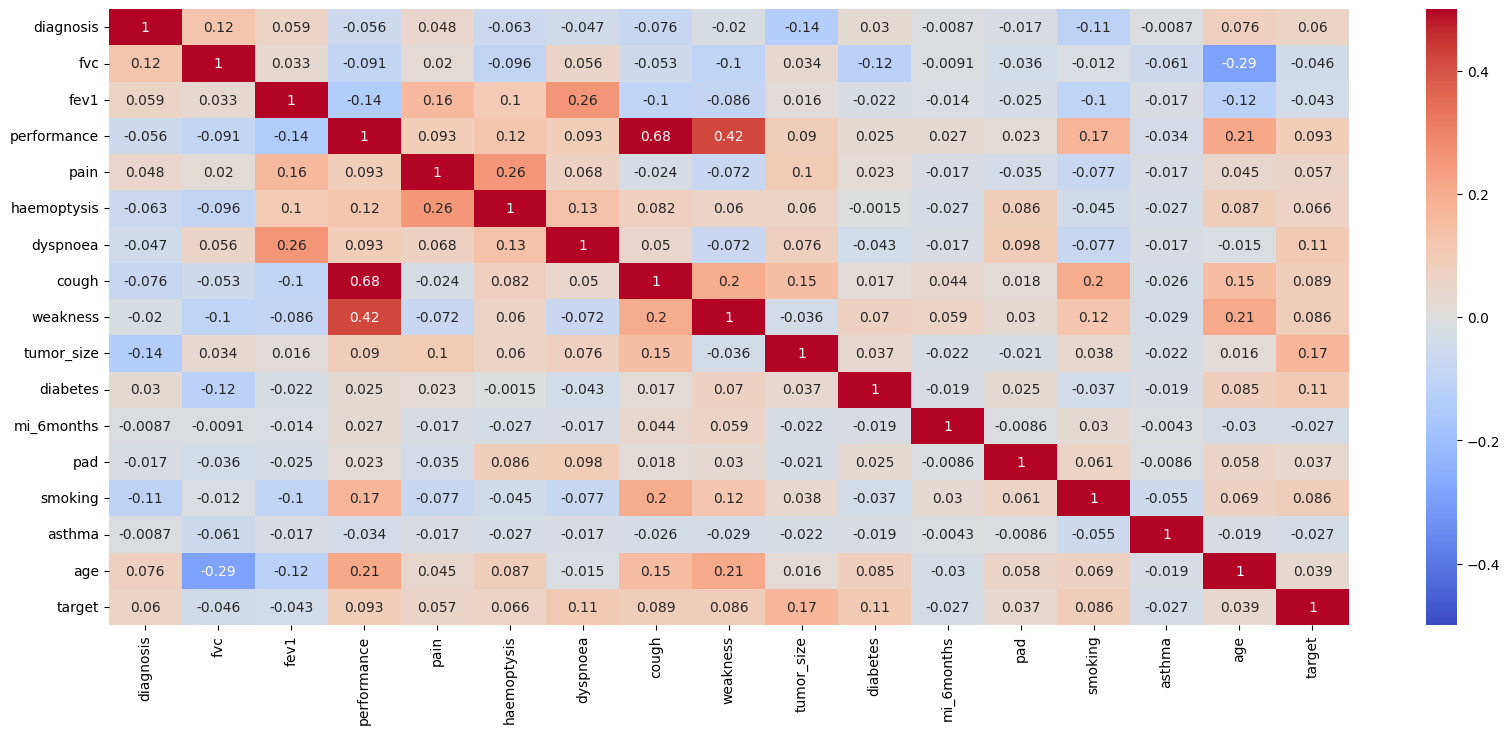

In [184]:

fig,ax = plt.subplots( figsize = (20,8))
_=sns.heatmap( df.corr(), cmap = 'coolwarm', vmin=-0.5, vmax= 0.5, annot = True  ) 


In [19]:
print( df.corr().loc['target'].sort_values() )


fvc           -0.046374
fev1          -0.042841
asthma        -0.027347
mi_6months    -0.027347
pad            0.037354
age            0.038902
pain           0.057375
diagnosis      0.060444
haemoptysis    0.065785
smoking        0.085958
weakness       0.086467
cough          0.088860
performance    0.093200
dyspnoea       0.105530
diabetes       0.108974
tumor_size     0.174371
target         1.000000
Name: target, dtype: float64


Text(0, 0.5, 'died fraction')

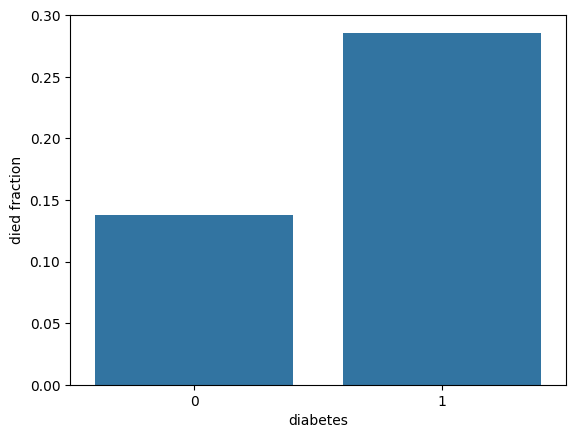

,diagnosis,fvc,fev1,performance,pain,haemoptysis,dyspnoea,cough,weakness,tumor_size,diabetes,mi_6months,pad,smoking,asthma,age
0,2,2.88,2.16,1,0,0,0,1,1,14,0,0,0,1,0,60.0
1,3,3.40,1.88,0,0,0,0,0,0,12,0,0,0,1,0,51.0
2,3,2.76,2.08,1,0,0,0,1,0,11,0,0,0,1,0,59.0
3,3,3.68,3.04,0,0,0,0,0,0,11,0,0,0,0,0,54.0
4,3,2.44,0.96,2,0,1,0,1,1,11,0,0,0,1,0,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,2,3.88,2.12,1,0,0,0,1,0,13,0,0,0,1,0,63.0
466,3,3.76,3.12,0,0,0,0,0,0,11,0,0,0,1,0,61.0
467,3,3.04,2.08,1,0,0,0,1,0,13,0,0,0,0,0,52.0
468,3,1.96,1.68,1,0,0,0,1,1,12,0,0,0,1,0,79.0


In [112]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

y,X = df['target'], df.drop( 'target', axis = 1  )
kbest = SelectKBest(chi2, k='all')
_= kbest.fit( X, y )
importance = pd.DataFrame( {'Feature': X.columns, 'chi2 score':kbest.scores_, 'pvalues': kbest.pvalues_})
importance.sort_values( by = 'chi2 score', ascending=False) 

,Feature,chi2 score,pvalues
2,fev1,26.090611,3.257643e-07
10,diabetes,5.165816,2.303563e-02
6,dyspnoea,4.888940,2.702927e-02
8,weakness,2.930815,8.690361e-02
5,haemoptysis,1.739706,1.871761e-01
3,performance,1.495368,2.213855e-01
4,pain,1.445161,2.293060e-01
7,cough,1.160725,2.813152e-01
15,age,0.860434,3.536174e-01
12,pad,0.644643,4.220345e-01


In [117]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

y,X = df['target'], df.drop( 'target', axis = 1  )
kbest = SelectKBest(f_classif, k='all')
_= kbest.fit( X, y )
importance = pd.DataFrame( {'Feature': X.columns, 'f score':kbest.scores_, 'pvalues': kbest.pvalues_})
importance.sort_values( by = 'f score', ascending=False) 

,Feature,f score,pvalues
9,tumor_size,14.675811,0.000145
10,diabetes,5.624499,0.018115
6,dyspnoea,5.270596,0.022130
3,performance,4.100741,0.043432
7,cough,3.724782,0.054215
8,weakness,3.525392,0.061057
13,smoking,3.483707,0.062601
5,haemoptysis,2.034132,0.154469
0,diagnosis,1.716125,0.190835
4,pain,1.545716,0.214391


In [110]:
print( nominal_features )

# only categorical 
X = df[ nominal_features ]
mutual_info_classif(X, y, discrete_features=True )
#from sklearn.feature_selection import f_classif
#X, y = load_iris(return_X_y=True)
#X.shape
#(150, 4)



['diagnosis', 'haemoptysis', 'dyspnoea', 'mi_6months', 'diabetes', 'weakness', 'pain', 'asthma', 'smoking', 'pad', 'cough']


array([0.01683251, 0.00200653, 0.00465171, 0.00068784, 0.00499331,
       0.00343275, 0.00147384, 0.00068784, 0.0041609 , 0.00060213,
       0.00418518])

In [111]:
X

,diagnosis,haemoptysis,dyspnoea,mi_6months,diabetes,weakness,pain,asthma,smoking,pad,cough
0,2,0,0,0,0,1,0,0,1,0,1
1,3,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,1,0,1
3,3,0,0,0,0,0,0,0,0,0,0
4,3,1,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
465,2,0,0,0,0,0,0,0,1,0,1
466,3,0,0,0,0,0,0,0,1,0,0
467,3,0,0,0,0,0,0,0,0,0,1
468,3,0,0,0,0,1,0,0,1,0,1


<Axes: xlabel='dyspnoea', ylabel='target'>

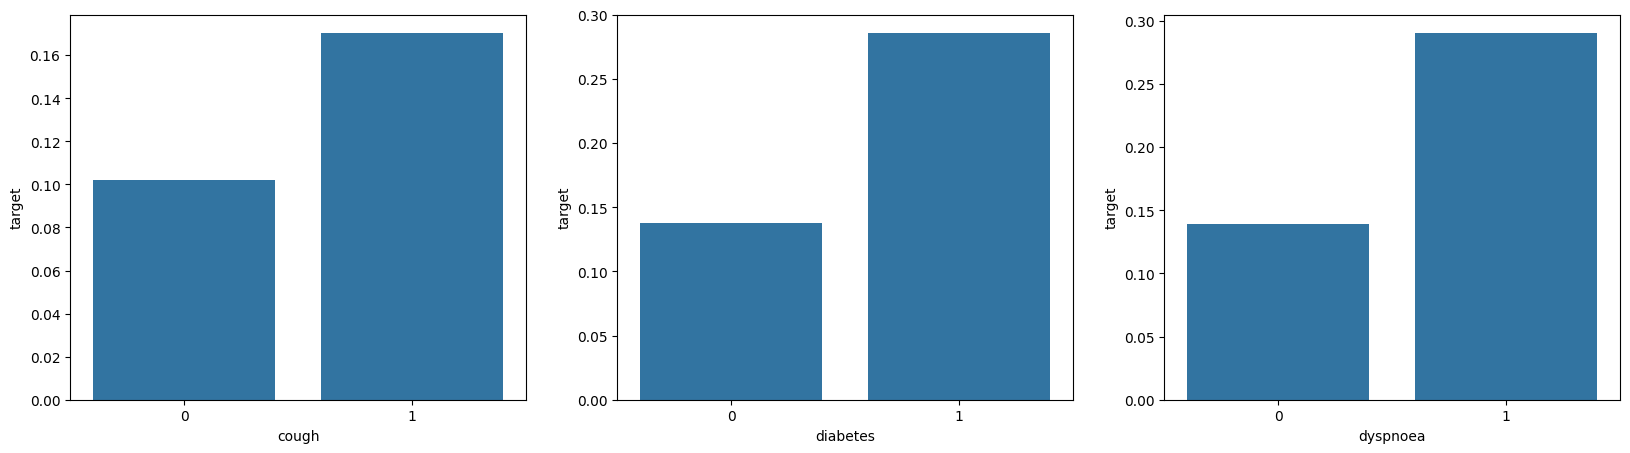

In [63]:
fig,ax = plt.subplots( nrows = 1 , ncols = 3, figsize = (20,5) )




sns.barplot( df.groupby( 'cough')['target'].mean(), ax = ax[0])
sns.barplot( df.groupby( 'diabetes')['target'].mean(), ax = ax[1] )
sns.barplot( df.groupby( 'dyspnoea')['target'].mean(), ax = ax[2] )



In [53]:
df['smoking'].value_counts()

1    386
0     84
Name: smoking, dtype: int64